In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd() + '/RKLM_Python/')
# from data_assimilation import letkf

from scipy.linalg import sqrtm

import importlib
# importlib.reload(letkf)
# %matplotlib inline

In [18]:
sigm = 10.
rho = 28.
beta = 8./3
dt = 0.001
Nout = int(50)
a = 1. / np.sqrt(dt)
fakt = 1.99999
N = int(2 * 10**5)

# initial conditions
x = -.587
y = -.563
z = 16.870
g1 = a * (1. / np.sqrt(2.) - .5)
g2 = a * (1. / np.sqrt(3.) - .5)
g3 = a * (1. / np.sqrt(5.) - .5)
res = np.zeros((N,7))

def gi(gi):
    if ((gi >= -a/2) and gi < 0):
        return a * (fakt * gi / a + 0.5)
    else:
        return a * (-fakt * gi / a + 0.5)
        
for i in range(N):
    res[i,:] = [i, x, y, z, g1, g2, g3]
    
    g1 = gi(g1)
    g2 = gi(g2)
    g3 = gi(g3)
    
    xn = x + dt * (sigm * (y - x)) + dt * g1
    yn = y + dt * (x * (rho - z) - y) + dt * g2
    zn = z + dt * (x * y - beta * z) + dt * g3
    
    x, y, z = xn, yn, zn
    
res[:,0] *= dt

# store only points with dt = 0.05
ressug = res[::Nout]

# add measurement error using tent map
meas = np.zeros((int(N)*4,2))
a = 4.
fakt = 1.99999
eta1 = a * (2.**(-1./2) - 0.5)

for i in range(N*4):
    if ((eta1 >= -a/2) and (eta1 < 0)):
        eta1 = (fakt * eta1 + 0.5 * a)
    else:
        eta1 = (-fakt * eta1 + 0.5 * a)
    meas[i] = [i+1, eta1]
    
measerr = meas[:,1][::10]

# observation of x-component (dt = 0.05, first 200 datapoints)
obsx = np.zeros((int(N/Nout),3))
j = 0
i = 0

for k in range(0,N,Nout):
    err = 1./20 * np.sum(measerr[j:j+20])
    obsx[i] = [res[k,0], res[k,1], err]
    i += 1
    j += 20
    
obsx = np.array(obsx)
obs = [obsx[:,0], obsx[:,1] + obsx[:,2]]
obs = np.array(obs)

In [154]:
def enkf_simple():
    None
    
# def forward_operator(X,R,M):
#     tmp = np.zeros_like(X.T)
#     print("tmp.shape = ", tmp.shape)
#     tmp[:,0] += np.sqrt(R) * np.random.randn(M)
#     print("tmp = ", tmp)
#     return lambda X : X + tmp

def forward_operator(X):
    return X[:,0]



In [155]:
STEPS = 5*40
R = 1./15

# recall that from example 4.8, the Lorenz model with drift term f(x) set to zero can be modelled 
# by a stochastic difference equation with mean = 0, var = 0.0838.
var = 0.0838

# sigma value given in example 6.9.
sigma = 0.1

NN = 20
m = np.arange(1,NN+1)
m = 2*m

lenm = len(m)

#m = np.array([4])

rmse_x = np.zeros((lenm))
rmse_y = np.zeros((lenm))
rmse_z = np.zeros((lenm))

for lkl in range(lenm):
    M = m[lkl]
    
    x0 = -0.587
    y0 = -0.563
    z0 = 16.87
    
    x = x0 + np.sqrt(sigma) * np.random.randn(M)
    y = y0 + np.sqrt(sigma) * np.random.randn(M)
    z = z0 + np.sqrt(sigma) * np.random.randn(M)
    t= np.zeros((STEPS+1))
    
    x_f = np.zeros((STEPS+1))
    y_f = np.zeros((STEPS+1))
    z_f = np.zeros((STEPS+1))
    
    x_f[0] = np.mean(x)
    y_f[0] = np.mean(y)
    z_f[0] = np.mean(z)
    
    rmse_x[lkl] = 0.
    rmse_y[lkl] = 0.
    rmse_z[lkl] = 0.
    
    cnt = 0
    
    for j in range(STEPS):
        xh = x
        yh = y
        zh = z
        
        for i in range(Nout):
            xo = xh
            yo = yh
            zo = zh
            
            # step within each observation window by means of the stochastic Lorenz-63 model
            xh = xo + dt * 10. * (yo-xo) + np.sqrt(dt * var) * np.random.randn(M)
            yh = yo + dt * (xo * (28. - zo) - yo) + np.sqrt(dt * var) * np.random.randn(M)
            zh = zo + dt * (xo * yo - 8./3 * zo) + np.sqrt(dt * var) * np.random.randn(M)
        
        x = xh
        y = yh
        z = zh
        
        X = np.vstack((x,y,z))
        
        obs_current = np.array([obs[1,j+1]]).reshape(1,-1)
    
        analysis = letkf.analysis(X.T)
        
        forward_op = forward_operator
        analysis.forward_operator = forward_op
    
        R_sp = np.array([R]).reshape(1,1)
        
        X = analysis.analyse(obs_current,R_sp).T

###################################EnKF-PO#####################################

        # Calculate residual: (forward map of reference - yobs)
#         r = xh - obs[1,j+1]

#         # Hz^f_i + eta_i - y_{obs} = rpert
#         rpert = r + np.sqrt(R) * np.random.randn(M)
#         dX = X - np.mean(X, axis=1).reshape(-1,1)

#         P = dX[:,:,None] * dX.T[None,:,:]
#         P = P.sum(axis=1)/(M-1)
#         K = P[:,0] / (P[0,0] + R)
#         X -= np.outer(K,rpert)

###################################ESRF#######################################

#         dX = X - np.mean(X, axis=1).reshape(-1,1)

#         P = dX[:,:,None] * dX.T[None,:,:]
#         print("P.shape = dX * dX.T = ", P.shape)
#         P = P.sum(axis=1)/(M-1)
#         print("P.shape after sum = ", P.shape)
        
        
#         K = P[:,0] / (P[0,0] + R)
#         print("K.shape = ", K.shape)
        
#         # mean of analysis, eqn 7.8
#         xmean = np.mean(X,axis=1)
#         xmean = xmean - K*(xmean[0] - obs[1,j+1])
        
#         # Get the S matrix, eqn 7.22
#         Y = dX[0,:] / np.sqrt(M-1)
#         Y = Y.reshape(-1,1) # to make transpose sensible - 1D arrays not transposable!
#         S2 = np.linalg.inv(sqrtm(np.eye(M) + Y.T * Y / R)).real
#         dX = np.dot(dX,S2)
        
#         X = xmean.reshape(-1,1) * np.ones(1,M) + dX
        
##############################################################################

        x = X[0,:]
        y = X[1,:]
        z = X[2,:]
        
        x_f[j+1] = np.mean(x)
        y_f[j+1] = np.mean(y)
        z_f[j+1] = np.mean(z)
        t[j+1] = dt * Nout * (j+1)
        
        rmse_x[lkl] = rmse_x[lkl] + (x_f[j+1] - ressug[j+1,1])**2
        rmse_y[lkl] = rmse_y[lkl] + (y_f[j+1] - ressug[j+1,2])**2
        rmse_z[lkl] = rmse_z[lkl] + (z_f[j+1] - ressug[j+1,3])**2
        
    rmse_x[lkl] = np.sqrt(rmse_x[lkl] / STEPS)
    rmse_y[lkl] = np.sqrt(rmse_y[lkl] / STEPS)
    rmse_z[lkl] = np.sqrt(rmse_z[lkl] / STEPS)


In [156]:
# rmse_letkf = [rmse_x, rmse_y, rmse_z]

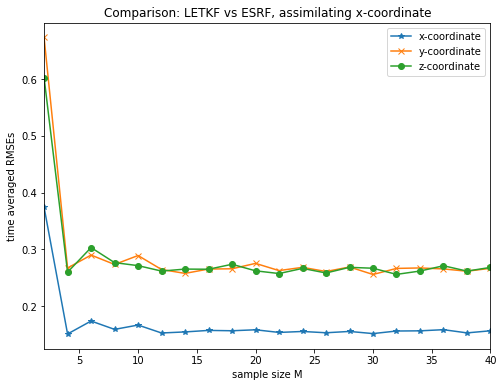

In [157]:
fig0a = plt.figure(figsize=(8,6))

plt.plot(m,rmse_x, '*-', label="x-coordinate")
plt.plot(m,rmse_y, 'x-', label="y-coordinate")
plt.plot(m,rmse_z, 'o-', label="z-coordinate")

# plt.plot(m,rmse_letkf[0], 'r*-', label="x-coordinate")
# plt.plot(m,rmse_letkf[1], 'rx-', label="y-coordinate")
# plt.plot(m,rmse_letkf[2], 'ro-', label="z-coordinate")

plt.xlim([2,40])
# plt.ylim([0,0.6])
plt.xlabel("sample size M")
plt.ylabel("time averaged RMSEs")
plt.title("Comparison: LETKF vs ESRF, assimilating x-coordinate")

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# legend_elements = [Line2D([0], [0], marker='*', color='k', label='x-coordinate',
#                           markerfacecolor='k', markersize=8),
#                    Line2D([0], [0], marker='x', color='k', label='y-coordinate',
#                           markerfacecolor='k', markersize=8),
#                    Line2D([0], [0], marker='o', color='k', label='z-coordinate',
#                           markerfacecolor='k', markersize=8),
#                    Line2D([0], [0], color='k', lw=4, label='ESRF'),
#                    Line2D([0], [0], color='r', lw=4, label='LETKF')]
# plt.legend(handles=legend_elements)

plt.legend()
plt.show()

In [158]:
A = np.arange(25).reshape(5,5)
print(A)
D = np.ones(5).reshape(-1,1) * 3
print(D)
print(A+D)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[[3.]
 [3.]
 [3.]
 [3.]
 [3.]]
[[ 3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12.]
 [13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22.]
 [23. 24. 25. 26. 27.]]


In [159]:
np.random.normal(0.0,0.5)

0.13993168403463577

[84 63 53]


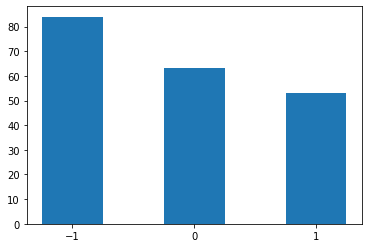

In [160]:
max_shift=1
lst = [np.random.randint(-max_shift,max_shift+1) for _ in range(200)]
hist, _ = np.histogram(lst,3)
print(hist)
plt.figure()
plt.hist(lst, bins=[-1.25,-0.75,-0.25,0.25,0.75,1.25])
plt.xticks([-1.0,0.0,1.0])
plt.show()

In [161]:
A = np.arange(25).reshape(5,5)
print(A)

inner = (slice(2,-2),slice(2,-2))

print(A[inner])

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[[12]]


(260, 260)
(32, 32)
(52, 52)


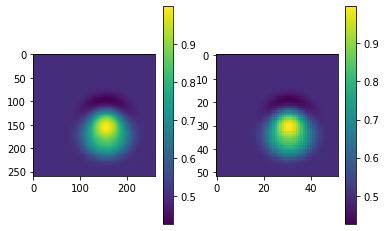

In [162]:
from scipy.signal import convolve2d
import h5py

# big = np.arange(65536).reshape(256,256)


file = h5py.File("../output_travelling_vortex/output_travelling_vortex_ensemble=1_256_256_1.0.h5", 'r')
big = file['rhov']['rhov_ensemble_mem=0_0.10_after_full_step'][:]
small = np.zeros((32,32))

ens_mem_shape = (52,52)
def bin_func(obs,ens_mem_shape):
    obs = obs.reshape(ens_mem_shape[0],obs.shape[0]//ens_mem_shape[0],
                      ens_mem_shape[1],obs.shape[1]//ens_mem_shape[1])
    return obs.mean(axis=(1,3))

print(big.shape)
print(small.shape)

small = bin_func(big,ens_mem_shape)
print(small.shape)
fig, ax = plt.subplots(1,2)
im = ax[0].imshow(big)
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(small)
plt.colorbar(im, ax=ax[1])
plt.show()

file.close()

In [167]:
print(4 // 3)

1


In [16]:
tout = np.arange(0,4801,100)
print(tout)
tout = np.arange(0,601,6)
print(tout)
tout = np.arange(0,301,3)/10.
print(tout)

print(np.linspace(0.0,10.0,101*2-1))
print(np.linspace(0.2,10.0,99))

[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700
 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100
 4200 4300 4400 4500 4600 4700 4800]
[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 600]
[ 0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  2.4  2.7  3.   3.3  3.6  3.9
  4.2  4.5  4.8  5.1  5.4  5.7  6.   6.3  6.6  6.9  7.2  7.5  7.8  8.1
  8.4  8.7  9.   9.3  9.6  9.9 10.2 10.5 10.8 11.1 11.4 11.7 12.  12.3
 12.6 12.9 13.2 13.5 13.8 14.1 14.4 14.7 15.  15.3 15.6 15.9 16.2 16.5
 16.8 17.1 17.4 17.7 18.  18.3 18.6 18.9 19.2 19.5 19.8

In [103]:
import numpy as np

# dependencies of the atmospheric flow solver
from management.data import data_init, time_update
from inputs.boundary import set_explicit_boundary_data
from management.variable import States, Vars
from physics.gas_dynamics.thermodynamic import ThemodynamicInit
from physics.gas_dynamics.eos import nonhydrostasy, compressibility, is_compressible, is_nonhydrostatic
from physics.gas_dynamics.gas_dynamics import dynamic_timestep
from physics.low_mach.mpv import MPV, acoustic_order

# input file
from inputs.travelling_vortex_3D_48 import UserData, sol_init
# from inputs.acoustic_wave_high import UserData, sol_init
# from inputs.internal_long_wave import UserData, sol_init
# from inputs.rising_bubble import UserData, sol_init
from inputs.user_data import UserDataInit

from data_assimilation import localisation
importlib.reload(localisation)

from scipy import sparse

np.set_printoptions(precision=18)

step = 0
t = 0.0

initial_data = vars(UserData())
ud = UserDataInit(**initial_data)

elem, node = data_init(ud)

flux = np.empty((3), dtype=object)
flux[0] = States(elem.sfx, ud)
if elem.ndim > 1:
    flux[1] = States(elem.sfy, ud)
if elem.ndim > 2:
    flux[2] = States(elem.sfz, ud)

th = ThemodynamicInit(ud)

mpv = MPV(elem, node, ud)

Sol = Vars(elem.sc, ud)
Sol = sol_init(Sol, mpv, elem, node, th, ud)

# elem.icx = 256+1
# elem.icy = 256+1

# sh = 32**2
# rlocal_stencil = localisation.rlocal_5pt(elem,node,ud)
# rlocal_stencil = sparse.linalg.LinearOperator((sh,sh),rlocal_stencil)
# ii = np.eye(sh,dtype='float')
# print(ii.shape)
# print(rlocal_stencil)
# covar = scipy.linalg.solve(rlocal_stencil, ii)
# covar = rlocal_stencil.matvec(ii.reshape(sh**2))
# covar = covar.reshape(sh,sh)

fig = plt.figure()
plt.spy(covar)
plt.show()

ValueError: dimension mismatch

[-3. -2. -1.  0.  1.  2.  3.]
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.05719096 0.25464401 0.33333333 0.25464401 0.05719096
  0.        ]
 [0.         0.25464401 0.52859548 0.66666667 0.52859548 0.25464401
  0.        ]
 [0.         0.33333333 0.66666667 1.         0.66666667 0.33333333
  0.        ]
 [0.         0.25464401 0.52859548 0.66666667 0.52859548 0.25464401
  0.        ]
 [0.         0.05719096 0.25464401 0.33333333 0.25464401 0.05719096
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]


<IPython.core.display.Javascript object>


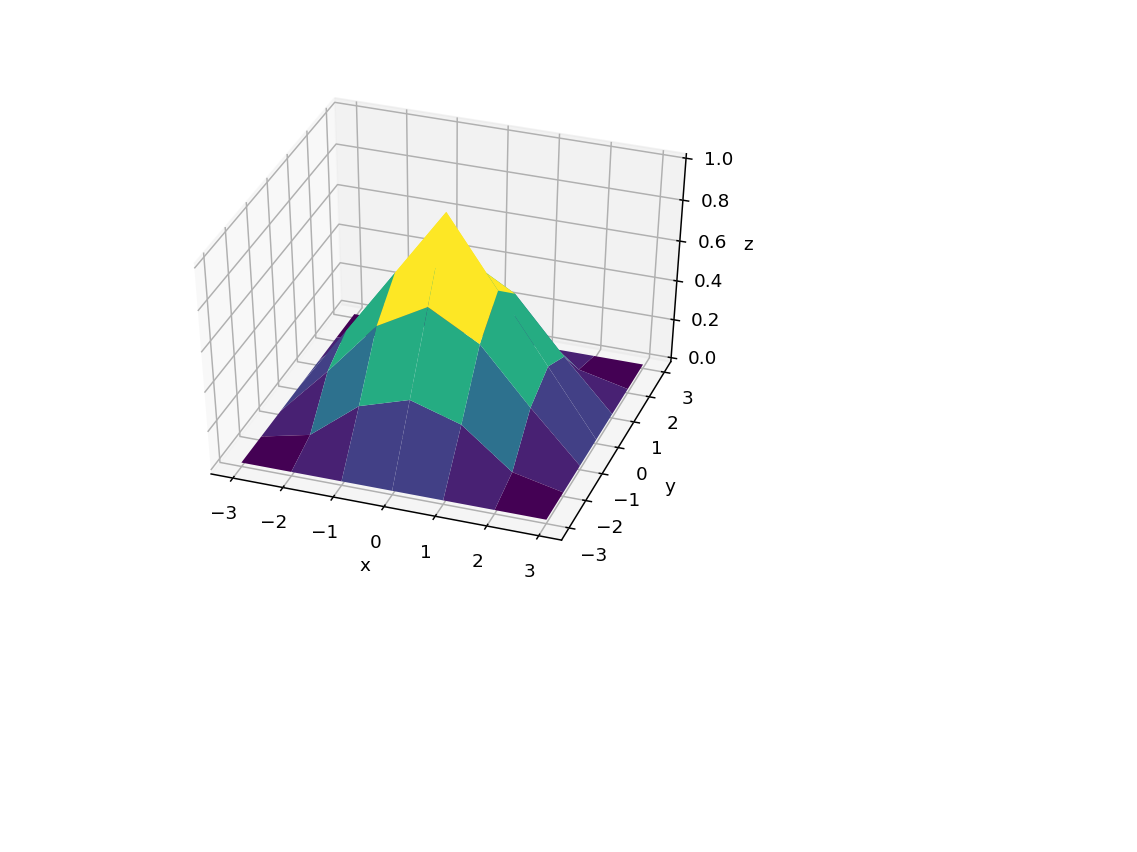

[0.05719096 0.25464401 0.33333333 0.25464401 0.05719096 0.25464401
 0.52859548 0.66666667 0.52859548 0.25464401 0.33333333 0.66666667
 1.         0.66666667 0.33333333 0.25464401 0.52859548 0.66666667
 0.52859548 0.25464401 0.05719096 0.25464401 0.33333333 0.25464401
 0.05719096]


In [51]:
from mpl_toolkits import mplot3d
from scipy import stats
%matplotlib notebook
x = (np.arange(0,7) - 3.0)

print(x)
X,Y = np.meshgrid(x,x)


Z = (3.0 - np.sqrt(X**2 + Y**2)) / 3.0
Z[np.where(Z < 0)] = 0.0


# x = np.arange(0,7) - 3.0
# # x = np.arange(0,100) - 50
# X,Y = np.meshgrid(x,x)

# pos = np.array([X.flatten(),Y.flatten()]).T
# norm = stats.multivariate_normal([0,0],[[1,0],[0,1]])
# Z = norm.pdf(pos).reshape(X.shape[0],X.shape[1])
# Z /= Z.max()
print(Z)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis',linewidth=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.set_xticks([-3,-2,-1,0,1,2,3])
# ax.set_yticks([-3,-2,-1,0,1,2,3]
plt.show()

print(Z[1:-1,1:-1].reshape(-1))

In [47]:
weights = [0.05719096,0.25464401,0.33333333,0.25464401,0.05719096,0.25464401,0.52859548,0.66666667,0.52859548,0.25464401,0.33333333,0.66666667,1.,0.66666667,0.33333333,0.25464401,0.52859548,0.66666667,0.52859548,0.25464401,0.05719096,0.25464401,0.33333333,0.25464401,0.05719096]
DD = np.diag(weights*3)
print(DD.shape)
print(DD)

(75, 75)
[[0.05719096 0.         0.         ... 0.         0.         0.        ]
 [0.         0.25464401 0.         ... 0.         0.         0.        ]
 [0.         0.         0.33333333 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.33333333 0.         0.        ]
 [0.         0.         0.         ... 0.         0.25464401 0.        ]
 [0.         0.         0.         ... 0.         0.         0.05719096]]
